In [1]:
# limit the thread used by numpy for better parallelization
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
# import logging

# sys.path.append("..")
from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import *
from Triangle.GW import *

try:
    import cupy as xp
    print("Has Cupy")
    HAS_GPU = True
except ImportError:
    import numpy as xp
    print("No Cupy")
    HAS_GPU = False

# import healpy as hlp

# Uncomment this if LaTeX is installed for better visualization
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

# logging.basicConfig()
# logging.getLogger().setLevel(logging.INFO)

import multiprocessing

if __name__ == "__main__":
    multiprocessing.set_start_method("fork")
print("number of cpus =", multiprocessing.cpu_count())
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# pool = None

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


No Cupy
number of cpus = 12


## General implementation 

In [3]:
# set the TCB times of resulting TDI responses
Tobs = 15 * DAY
dt = 5.0
tcb_times = np.arange(int(Tobs / dt)) * dt

# orbit model
orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")

In [4]:
# approximant = "IMRPhenomXHM"
approximant = "SEOBNRv4_opt"
mbhb_waveform_generator = MBHB_Injection(approx_method=approximant, buffer=False)

mbhb_response_generator = GeneralTDIResponse(
    orbit=orbit,
    Pstring=GeneralTDIResponse.X2_strings,
    tcb_times=tcb_times.copy(),
    use_gpu=False,
    drop_points=int(1000 / dt),
    linear_interp=False,
    return_eta=False, 
)

In [5]:
MBHB_params = {
    "chirp_mass": 400000.0,
    "mass_ratio": 0.3640815267051051,
    "spin_1z": 0.7899406190510447,
    "spin_2z": 0.015424596359292053,
    "coalescence_time": 12.0,
    "coalescence_phase": 3.2535342675592966,
    "luminosity_distance": 106039.10941463517,
    "inclination": 1.4495086550199021,
    "longitude": 3.032776598141215,
    "latitude": -1.1817968279048852,
    "psi": 0.2409146690555858,
}

In [6]:
for _ in tqdm(range(100)):
    results = mbhb_response_generator(parameters=MBHB_params, waveform_generator=mbhb_waveform_generator)

100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


(11.98, 12.01)

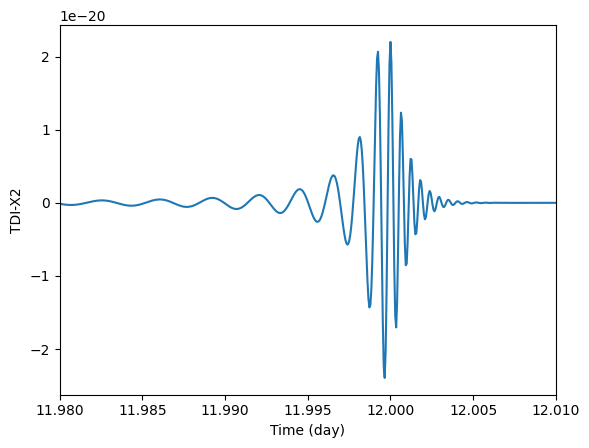

In [7]:
plt.plot(tcb_times / DAY, results)
plt.xlabel("Time (day)")
plt.ylabel("TDI-X2")
# plt.ylim(-1e-23, 1e-23)
plt.xlim(MBHB_params["coalescence_time"] - 0.02, MBHB_params["coalescence_time"] + 0.01)

## Faster implementation 

In [8]:
import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    print("no cupy ")

no cupy 


In [9]:

class FastMichelsonTDIResponse:
    GB_param_names = ["A", "f0", "fdot0", "phase0", "inclination", "longitude", "latitude", "psi"]
    MBHB_param_names = ["chirp_mass", "mass_ratio", "spin_1z", "spin_2z", "coalescence_time", "coalescence_phase", "luminosity_distance", "inclination", "longitude", "latitude", "psi"]
    MBHB_v5_param_names = ["chirp_mass", "mass_ratio", "spin_1z", "spin_2z", "coalescence_time", "reference_phase", "luminosity_distance", "inclination", "longitude", "latitude", "psi", "eccentricity"]
    general_param_names = ["longitude", "latitude", "psi"]

    def __init__(self, orbit, tcb_times, use_gpu=False, drop_points=0, interp_method="linear"):
        """
        Initialize orbit-specified time delays, which will be used to calculate single-link responses and TDIs 
        Args:
            orbit: an orbit object
            tcb_times: TCB times at which the TDI responses will be calculated, numpy or cupy arraies 
            use_gpu: if True, the waveform generator should takes cupy arraies as inputs and outputs cupy arraies
            interp_method shoude be chosen from "linear", "Akima", "Spline3", "Spline4", "Spline5"
        """
        self.orbit_object = orbit
        self.Ntime = len(tcb_times)
        self.use_gpu = use_gpu
        self.drop_points = drop_points
        
        if use_gpu: 
            self.xp = xp 
            self.xinterp = xinterp
        else: 
            self.xp = np 
            self.xinterp = interp
        self.SIN = self.xp.sin
        self.COS = self.xp.cos 
        self.MATMUL = self.xp.matmul
        self.REAL = self.xp.real
        self.IMAG = self.xp.imag
        
        if interp_method == "linear": 
            self.linear_interp = True 
            self.LIN_INTERP = self.xp.interp
        else: 
            self.linear_interp = False 
            if interp_method == "Akima": 
                self.spline_interp = False 
                self.interp_class = self.xinterp.Akima1DInterpolator
            elif interp_method == "Spline3": 
                self.spline_interp = True 
                self.interp_class = self.xinterp.make_interp_spline
                self.interp_k_order = 3 
            elif interp_method == "Spline4": 
                self.spline_interp = True
                self.interp_class = self.xinterp.make_interp_spline
                self.interp_k_order = 4 
            elif interp_method == "Spline5": 
                self.spline_interp = True
                self.interp_class = self.xinterp.make_interp_spline
                self.interp_k_order = 5 
            else: 
                raise NotImplementedError("Interpolation method not implemented.")
            
        # the orbit functions use numpy array as input
        if isinstance(tcb_times, xp.ndarray) and HAS_GPU:
            self.tcb_times = tcb_times.get() # now self.tcb_times is a numpy array 
        else: 
            self.tcb_times = tcb_times.copy() # now self.tcb_times is a numpy array 
            
        # calculate TDI delays 
        # 1-link delays 
        self.d12 = self.xp.array(orbit.LTTfunctions()["12"](self.tcb_times)) # (Nt,)
        self.d23 = self.xp.array(orbit.LTTfunctions()["23"](self.tcb_times))
        self.d31 = self.xp.array(orbit.LTTfunctions()["31"](self.tcb_times))
        self.d21 = self.xp.array(orbit.LTTfunctions()["21"](self.tcb_times))
        self.d32 = self.xp.array(orbit.LTTfunctions()["32"](self.tcb_times))
        self.d13 = self.xp.array(orbit.LTTfunctions()["13"](self.tcb_times))
        # 2-link delays 
        self.d212 = self.d21 + self.d12 # (Nt,) some of the variables are duplicated, but it won't affect the speed of response calculation 
        self.d232 = self.d23 + self.d32 
        self.d323 = self.d32 + self.d23 
        self.d313 = self.d31 + self.d13 
        self.d131 = self.d13 + self.d31 
        self.d121 = self.d12 + self.d21 
        # 4-link delays 
        self.d23212 = self.d232 + self.d212 # (Nt,)
        self.d31323 = self.d313 + self.d323 
        self.d12131 = self.d121 + self.d131 

        # calculate orbit variables 
        # arm vectors 
        self.arm_vector_dict = assign_function_for_MOSAs(
            functions=orbit.ArmVectorfunctions(),
            proper_time=self.tcb_times,
        )  
        for key in MOSA_labels:
            self.arm_vector_dict[key] = self.xp.array(self.arm_vector_dict[key]) # each item is a xp array of shape (Ntime, 3)
        # position vectors 
        self.position_vector_dict = assign_function_for_SCs(
            functions=orbit.Positionfunctions(), 
            proper_time=self.tcb_times, 
        )
        for key in SC_labels: 
            self.position_vector_dict[key] = self.xp.array(self.position_vector_dict[key]) # each item is a xp array of shape (Ntime, 3)

        self.tcb_times = self.xp.array(self.tcb_times) 
        self.ep_0 = self.xp.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]])
        self.ec_0 = self.xp.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]])

    def __call__(self, parameters, waveform_generator, optimal_combination=False):
        """
        Args:
            parameters: a dictionary storing the source parameters
            waveform_generator: a waveform object, which has a __call__ function that returns source-frame polarizations hp + ihc for given parameters
        Returns:
            the time series of TDI responses XYZ (optimal_combination=False) or AET (optimal_combination=True), shape is (3, Nt)
        """
        self.waveform_generator = waveform_generator

        # calculate wave vector and polar bases using the extrinsic parameters
        l = parameters["longitude"]
        b = parameters["latitude"]
        p = parameters["psi"]

        wave_vector = -self.xp.array([self.COS(l) * self.COS(b), self.SIN(l) * self.COS(b), self.SIN(b)])  # (3)

        O = self.xp.zeros((3, 3))
        O[0][0] = self.SIN(l) * self.COS(p) - self.COS(l) * self.SIN(b) * self.SIN(p)
        O[0][1] = -self.SIN(l) * self.SIN(p) - self.COS(l) * self.SIN(b) * self.COS(p)
        O[0][2] = -self.COS(l) * self.COS(b)
        O[1][0] = -self.COS(l) * self.COS(p) - self.SIN(l) * self.SIN(b) * self.SIN(p)
        O[1][1] = self.COS(l) * self.SIN(p) - self.SIN(l) * self.SIN(b) * self.COS(p)
        O[1][2] = -self.SIN(l) * self.COS(b)
        O[2][0] = self.COS(b) * self.SIN(p)
        O[2][1] = self.COS(b) * self.COS(p)
        O[2][2] = -self.SIN(b)
        OT = O.transpose()
        e_p = self.xp.dot(self.xp.dot(O, self.ep_0), OT)  # (3, 3)
        e_c = self.xp.dot(self.xp.dot(O, self.ec_0), OT)  # (3, 3)

        # calculate fiducial waveforms at tcb_times, and the delayed ones will be obtained via interpolation
        times_interp, hphc0 = self.waveform_generator(parameters, self.tcb_times)  # times_interp does not has to be the same as tcb_times, it only acts as the x value of interpolation

        # calculate pattern function 
        Fp12 = self.xp.sum(self.MATMUL(self.arm_vector_dict["12"], e_p) * self.arm_vector_dict["12"], axis=1)  # Fp12=Fp21 (Ntime)
        Fp23 = self.xp.sum(self.MATMUL(self.arm_vector_dict["23"], e_p) * self.arm_vector_dict["23"], axis=1)
        Fp31 = self.xp.sum(self.MATMUL(self.arm_vector_dict["31"], e_p) * self.arm_vector_dict["31"], axis=1)
        Fc12 = self.xp.sum(self.MATMUL(self.arm_vector_dict["12"], e_c) * self.arm_vector_dict["12"], axis=1)  # Fc12=Fc21 (Ntime)
        Fc23 = self.xp.sum(self.MATMUL(self.arm_vector_dict["23"], e_c) * self.arm_vector_dict["23"], axis=1)
        Fc31 = self.xp.sum(self.MATMUL(self.arm_vector_dict["31"], e_c) * self.arm_vector_dict["31"], axis=1)
        
        Denominator12 = (self.MATMUL(self.arm_vector_dict["12"], wave_vector) - 1.0) * (-2.0)  # (Ntime)
        Denominator23 = (self.MATMUL(self.arm_vector_dict["23"], wave_vector) - 1.0) * (-2.0) 
        Denominator31 = (self.MATMUL(self.arm_vector_dict["31"], wave_vector) - 1.0) * (-2.0)  
        Denominator21 = (self.MATMUL(self.arm_vector_dict["21"], wave_vector) - 1.0) * (-2.0)  
        Denominator32 = (self.MATMUL(self.arm_vector_dict["32"], wave_vector) - 1.0) * (-2.0) 
        Denominator13 = (self.MATMUL(self.arm_vector_dict["13"], wave_vector) - 1.0) * (-2.0)  
        
        kR1overC = self.MATMUL(self.position_vector_dict["1"], wave_vector) / C # (Ntime)
        kR2overC = self.MATMUL(self.position_vector_dict["2"], wave_vector) / C 
        kR3overC = self.MATMUL(self.position_vector_dict["3"], wave_vector) / C 
            
        if self.linear_interp:      
            dh12 = self.LIN_INTERP(x=self.tcb_times - self.d12 - kR2overC, xp=times_interp, fp=hphc0, left=0., right=0.) - self.LIN_INTERP(x=self.tcb_times - kR1overC, xp=times_interp, fp=hphc0, left=0., right=0.) # (Ntime), complex 
            dh23 = self.LIN_INTERP(x=self.tcb_times - self.d23 - kR3overC, xp=times_interp, fp=hphc0, left=0., right=0.) - self.LIN_INTERP(x=self.tcb_times - kR2overC, xp=times_interp, fp=hphc0, left=0., right=0.)
            dh31 = self.LIN_INTERP(x=self.tcb_times - self.d31 - kR1overC, xp=times_interp, fp=hphc0, left=0., right=0.) - self.LIN_INTERP(x=self.tcb_times - kR3overC, xp=times_interp, fp=hphc0, left=0., right=0.)
            dh21 = self.LIN_INTERP(x=self.tcb_times - self.d21 - kR1overC, xp=times_interp, fp=hphc0, left=0., right=0.) - self.LIN_INTERP(x=self.tcb_times - kR2overC, xp=times_interp, fp=hphc0, left=0., right=0.)
            dh32 = self.LIN_INTERP(x=self.tcb_times - self.d32 - kR2overC, xp=times_interp, fp=hphc0, left=0., right=0.) - self.LIN_INTERP(x=self.tcb_times - kR3overC, xp=times_interp, fp=hphc0, left=0., right=0.)
            dh13 = self.LIN_INTERP(x=self.tcb_times - self.d13 - kR3overC, xp=times_interp, fp=hphc0, left=0., right=0.) - self.LIN_INTERP(x=self.tcb_times - kR1overC, xp=times_interp, fp=hphc0, left=0., right=0.)
            
            eta12 = (Fp12 * self.REAL(dh12) + Fc12 * self.IMAG(dh12)) / Denominator12 # (Ntime)
            eta23 = (Fp23 * self.REAL(dh23) + Fc23 * self.IMAG(dh23)) / Denominator23
            eta31 = (Fp31 * self.REAL(dh31) + Fc31 * self.IMAG(dh31)) / Denominator31
            eta21 = (Fp12 * self.REAL(dh21) + Fc12 * self.IMAG(dh21)) / Denominator21
            eta32 = (Fp23 * self.REAL(dh32) + Fc23 * self.IMAG(dh32)) / Denominator32
            eta13 = (Fp31 * self.REAL(dh13) + Fc31 * self.IMAG(dh13)) / Denominator13
            
            X0plus = eta12 + self.LIN_INTERP(x=self.tcb_times - self.d12, xp=self.tcb_times, fp=eta21, left=0., right=0.)
            X0minus = eta13 + self.LIN_INTERP(x=self.tcb_times - self.d13, xp=self.tcb_times, fp=eta31, left=0., right=0.)
            X1plus = X0plus - self.LIN_INTERP(x=self.tcb_times - self.d131, xp=self.tcb_times, fp=X0plus, left=0., right=0.)
            X1minus = X0minus - self.LIN_INTERP(x=self.tcb_times - self.d121, xp=self.tcb_times, fp=X0minus, left=0., right=0.) 
            X2_tmp = X1plus - X1minus
            X2 = X2_tmp - self.LIN_INTERP(x=self.tcb_times - self.d12131, xp=self.tcb_times, fp=X2_tmp, left=0., right=0.) # (Ntime)
            
            Y0plus = eta23 + self.LIN_INTERP(x=self.tcb_times - self.d23, xp=self.tcb_times, fp=eta32, left=0., right=0.)
            Y0minus = eta21 + self.LIN_INTERP(x=self.tcb_times - self.d21, xp=self.tcb_times, fp=eta12, left=0., right=0.)
            Y1plus = Y0plus - self.LIN_INTERP(x=self.tcb_times - self.d212, xp=self.tcb_times, fp=Y0plus, left=0., right=0.)
            Y1minus = Y0minus - self.LIN_INTERP(x=self.tcb_times - self.d232, xp=self.tcb_times, fp=Y0minus, left=0., right=0.) 
            Y2_tmp = Y1plus - Y1minus
            Y2 = Y2_tmp - self.LIN_INTERP(x=self.tcb_times - self.d23212, xp=self.tcb_times, fp=Y2_tmp, left=0., right=0.) # (Ntime)

            Z0plus = eta31 + self.LIN_INTERP(x=self.tcb_times - self.d31, xp=self.tcb_times, fp=eta13, left=0., right=0.)
            Z0minus = eta32 + self.LIN_INTERP(x=self.tcb_times - self.d32, xp=self.tcb_times, fp=eta23, left=0., right=0.)
            Z1plus = Z0plus - self.LIN_INTERP(x=self.tcb_times - self.d323, xp=self.tcb_times, fp=Z0plus, left=0., right=0.)
            Z1minus = Z0minus - self.LIN_INTERP(x=self.tcb_times - self.d313, xp=self.tcb_times, fp=Z0minus, left=0., right=0.) 
            Z2_tmp = Z1plus - Z1minus
            Z2 = Z2_tmp - self.LIN_INTERP(x=self.tcb_times - self.d31323, xp=self.tcb_times, fp=Z2_tmp, left=0., right=0.) # (Ntime)

        else:
            if self.spline_interp:            
                hp_func = self.interp_class(x=times_interp, y=self.REAL(hphc0), k=self.interp_k_order)
                hc_func = self.interp_class(x=times_interp, y=self.IMAG(hphc0), k=self.interp_k_order)
            else: 
                hp_func = self.interp_class(x=times_interp, y=self.REAL(hphc0))
                hc_func = self.interp_class(x=times_interp, y=self.IMAG(hphc0))
                
            t_send = self.tcb_times - self.d12 - kR2overC
            t_recv = self.tcb_times - kR1overC
            dhp12 = hp_func(t_send, extrapolate=True) - hp_func(t_recv, extrapolate=True) # (Ntime)
            dhc12 = hc_func(t_send, extrapolate=True) - hc_func(t_recv, extrapolate=True)
            
            t_send = self.tcb_times - self.d23 - kR3overC
            t_recv = self.tcb_times - kR2overC
            dhp23 = hp_func(t_send, extrapolate=True) - hp_func(t_recv, extrapolate=True) # (Ntime)
            dhc23 = hc_func(t_send, extrapolate=True) - hc_func(t_recv, extrapolate=True)
            
            t_send = self.tcb_times - self.d31 - kR1overC
            t_recv = self.tcb_times - kR3overC
            dhp31 = hp_func(t_send, extrapolate=True) - hp_func(t_recv, extrapolate=True) # (Ntime)
            dhc31 = hc_func(t_send, extrapolate=True) - hc_func(t_recv, extrapolate=True)
            
            t_send = self.tcb_times - self.d21 - kR1overC
            t_recv = self.tcb_times - kR2overC
            dhp21 = hp_func(t_send, extrapolate=True) - hp_func(t_recv, extrapolate=True) # (Ntime)
            dhc21 = hc_func(t_send, extrapolate=True) - hc_func(t_recv, extrapolate=True)
            
            t_send = self.tcb_times - self.d32 - kR2overC
            t_recv = self.tcb_times - kR3overC
            dhp32 = hp_func(t_send, extrapolate=True) - hp_func(t_recv, extrapolate=True) # (Ntime)
            dhc32 = hc_func(t_send, extrapolate=True) - hc_func(t_recv, extrapolate=True)
            
            t_send = self.tcb_times - self.d13 - kR3overC
            t_recv = self.tcb_times - kR1overC
            dhp13 = hp_func(t_send, extrapolate=True) - hp_func(t_recv, extrapolate=True) # (Ntime)
            dhc13 = hc_func(t_send, extrapolate=True) - hc_func(t_recv, extrapolate=True)
            
            eta12 = (Fp12 * dhp12 + Fc12 * dhc12) / Denominator12 # (Ntime)
            eta23 = (Fp23 * dhp23 + Fc23 * dhc23) / Denominator23
            eta31 = (Fp31 * dhp31 + Fc31 * dhc31) / Denominator31
            eta21 = (Fp12 * dhp21 + Fc12 * dhc21) / Denominator21
            eta32 = (Fp23 * dhp32 + Fc23 * dhc32) / Denominator32
            eta13 = (Fp31 * dhp13 + Fc31 * dhc13) / Denominator13
            
            if self.spline_interp:
                eta12_func = self.interp_class(x=self.tcb_times, y=eta12, k=self.interp_k_order)
                eta23_func = self.interp_class(x=self.tcb_times, y=eta23, k=self.interp_k_order)
                eta31_func = self.interp_class(x=self.tcb_times, y=eta31, k=self.interp_k_order)
                eta21_func = self.interp_class(x=self.tcb_times, y=eta21, k=self.interp_k_order)
                eta32_func = self.interp_class(x=self.tcb_times, y=eta32, k=self.interp_k_order)
                eta13_func = self.interp_class(x=self.tcb_times, y=eta13, k=self.interp_k_order)
            else:
                eta12_func = self.interp_class(x=self.tcb_times, y=eta12)
                eta23_func = self.interp_class(x=self.tcb_times, y=eta23)
                eta31_func = self.interp_class(x=self.tcb_times, y=eta31)
                eta21_func = self.interp_class(x=self.tcb_times, y=eta21)
                eta32_func = self.interp_class(x=self.tcb_times, y=eta32)
                eta13_func = self.interp_class(x=self.tcb_times, y=eta13)
            
            X2 = eta12 - eta12_func(self.tcb_times-self.d131, extrapolate=True) - eta12_func(self.tcb_times-self.d12131, extrapolate=True) + eta12_func(self.tcb_times-self.d12131-self.d131, extrapolate=True) \
                - eta31_func(self.tcb_times - self.d13, extrapolate=True) + eta31_func(self.tcb_times - self.d121 - self.d13, extrapolate=True) + eta31_func(self.tcb_times - self.d12131 - self.d13, extrapolate=True) - eta13_func(self.tcb_times - self.d12131 - self.d121 - self.d13, extrapolate=True) \
                + eta21_func(self.tcb_times - self.d12, extrapolate=True) - eta21_func(self.tcb_times - self.d131 - self.d12, extrapolate=True) - eta21_func(self.tcb_times - self.d12131 - self.d12, extrapolate=True) + eta21_func(self.tcb_times - self.d12131 - self.d131 - self.d12, extrapolate=True) \
                - eta13 + eta13_func(self.tcb_times - self.d121, extrapolate=True) + eta13_func(self.tcb_times - self.d12131, extrapolate=True) - eta13_func(self.tcb_times - self.d12131 - self.d121, extrapolate=True)

            Y2 = eta23 - eta23_func(self.tcb_times-self.d212, extrapolate=True) - eta23_func(self.tcb_times-self.d23212, extrapolate=True) + eta23_func(self.tcb_times-self.d23212-self.d212, extrapolate=True) \
                - eta12_func(self.tcb_times - self.d21, extrapolate=True) + eta12_func(self.tcb_times - self.d232 - self.d21, extrapolate=True) + eta12_func(self.tcb_times - self.d23212 - self.d21, extrapolate=True) - eta21_func(self.tcb_times - self.d23212 - self.d232 - self.d21, extrapolate=True) \
                + eta32_func(self.tcb_times - self.d23, extrapolate=True) - eta32_func(self.tcb_times - self.d212 - self.d23, extrapolate=True) - eta32_func(self.tcb_times - self.d23212 - self.d23, extrapolate=True) + eta32_func(self.tcb_times - self.d23212 - self.d212 - self.d23, extrapolate=True) \
                - eta21 + eta21_func(self.tcb_times - self.d232, extrapolate=True) + eta21_func(self.tcb_times - self.d23212, extrapolate=True) - eta21_func(self.tcb_times - self.d23212 - self.d232, extrapolate=True)

            Z2 = eta31 - eta31_func(self.tcb_times-self.d323, extrapolate=True) - eta31_func(self.tcb_times-self.d31323, extrapolate=True) + eta31_func(self.tcb_times-self.d31323-self.d323, extrapolate=True) \
                - eta23_func(self.tcb_times - self.d32, extrapolate=True) + eta23_func(self.tcb_times - self.d313 - self.d32, extrapolate=True) + eta23_func(self.tcb_times - self.d31323 - self.d32, extrapolate=True) - eta32_func(self.tcb_times - self.d31323 - self.d313 - self.d32, extrapolate=True) \
                + eta13_func(self.tcb_times - self.d31, extrapolate=True) - eta13_func(self.tcb_times - self.d323 - self.d31, extrapolate=True) - eta13_func(self.tcb_times - self.d31323 - self.d31, extrapolate=True) + eta13_func(self.tcb_times - self.d31323 - self.d323 - self.d31, extrapolate=True) \
                - eta32 + eta32_func(self.tcb_times - self.d313, extrapolate=True) + eta32_func(self.tcb_times - self.d31323, extrapolate=True) - eta32_func(self.tcb_times - self.d31323 - self.d313, extrapolate=True)
                
        if optimal_combination: 
            A2, E2, T2 = AETfromXYZ(X2, Y2, Z2)
            res_arr = self.xp.array([A2, E2, T2])
        else: 
            res_arr = self.xp.array([X2, Y2, Z2])
        res_arr[:, :self.drop_points] *= 0. 
        res_arr[:, -self.drop_points:] *= 0. 
        return res_arr

(-0.001, 0.001)

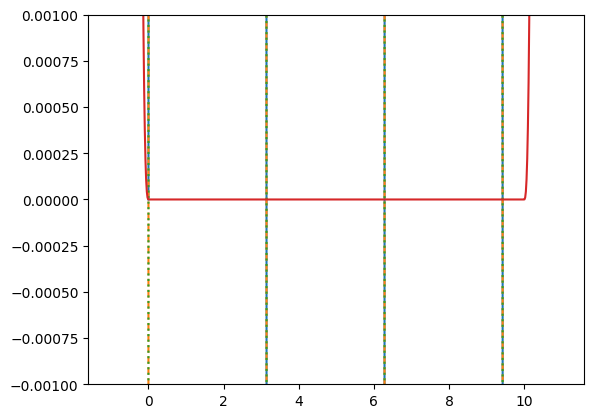

In [10]:
xx = np.linspace(0, 10, 1000)
yy = np.sin(xx)

xx_eval = np.linspace(-1, 11, 666)

yyfunc = xinterp.make_interp_spline(x=xx, y=yy, k=5)
yy_eval = yyfunc(xx_eval, extrapolate=True)

yyfunc1 = xinterp.Akima1DInterpolator(x=xx, y=yy)
yy_eval1 = yyfunc1(xx_eval, extrapolate=True)

plt.plot(xx, yy)
plt.plot(xx_eval, yy_eval, linestyle="--")
plt.plot(xx_eval, yy_eval1, linestyle=":")
plt.plot(xx_eval, yy_eval - yy_eval1)
plt.ylim(-1e-3, 1e-3)